# DCSI 100 Group Project

## By Alec Jessen, Avery Swoboda, Daniel Wick, Naya Bhatthal 


# Title: An Investigation into the Factors that help Set up a Top Tennis Player for Success

## Introduction:

Tennis is a racquet sport played between one another or teams of 2 opposing each other. It is unclear whether or not certain variables, such as height or age, influence performance and results during a tennis match. In the data set, we are investigating different variables such as height, age, and playing style to determine if there is any correlation (positive or negative) between these factors and the overall performance of the player. Furthermore, we aim to understand if the amount of prize money earned or ranking is supported by the possible correlation between the variables and how these determine a single player’s success.

## Question: “How do variables such as age, backhand playing style (two-handed vs. one-handed) and experience have an effect, if any, on a tennis player’s success level, as measured by current and best rank and prize money earned?”

The dataset analysed to answer the above question will be “Player Stats for Top 500 Players” from ultimate tennis statistics.com. It is a detailed dataset that contains information about the name, age, country of origin, playing style (right-handed or left-handed), backhand (one-handed or two-handed), current and best ranking, current, best and peak elo rating, prize money earned for the top 500 tennis players worldwide, among other variables about their professional life about resources of information acquisition.

## Methods and Data Analysis

To begin we loaded the necessary libraries to conduct our data analysis and installed a few packages pertaining to functions not as commonly used in the classroom. The janitor package contains key functions for cleaning and analyzing data, such as "clean_names." GGally provides various methods for visualizing  relationships, such as pairwise plots via the function "ggpairs."The ISLR (Introduction to Statistical Learning with Applications in R) also includes functions used in the textbook that we will employ. The "Patchwork" library allows for improved formatting of ggplot2 plots. 

In [35]:
#install.packages("rlang")
#install.packages("readr")
#install.packages("dplyr")
#install.packages("ggplot2")
#install.packages("tidyverse")
#install.packages("rvest")
#install.packages("tidymodels")

#install.packages("janitor")
#install.packages("GGally")
#install.packages("ISLR")

library(rlang)
library(dplyr)
library(tidyverse)
library(tidymodels)
library(janitor)
library(rsample)
library(ggplot2)
library(repr)
library(GGally)
library(ISLR)

First, we downloaded the tennis dataset from the indicated website and saved it locally as "player_stats.csv." As the data set is separated by semicolons, we then used the "read_csv" function to read the file into a data frame named "tennis_data". The "clean_names" function was used to standardize the column names to only include lowercase letters and underscores rather than spaces. We then selected the subset of columns relevant to our investigation. The "na.omit" function was used to delete rows with missing values.

To create the new tidy dataset named "tennis_data_tidy", we transformed the "age," "current_rank," and "best_rank" columns from character (chr) to numeric (dbl) forms. We used additional expressions to extract the numeric values from the "prize_money" column in particular, as it contained extra characters describing the rank and special statuses of the players. We also used the "mutate" function to create additional variables, such as "current_rank_rev" and "best_rank_rev", so that higher values indicate a higher ranking during the interpretation of the variables. To do this, the original ranks were subtracted from 501, the total number of ranks in the dataset plus one so that the rank one player would be at 500 instead of 499. After visualizing best rank versus prize money we noted that prize money contains a non-linear distribution of funds by rank with a large proportion of funds being given to the top performing players so we established a variable called "log_prize_money," which denotes the base-10 logarithm of "prize_money." We then used the "head" function to display a preview of our tidy dataset.

In [36]:
# Download the tennis data file from the web into a local .csv file, then tidy the data specific for our analysis

# Make sure this "#" below is removed before submission  !!!!!   (leave for testing for now)
#download.file("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS","player_stats.csv")
tennis_data <- read_csv("player_stats.csv", show_col_types = FALSE)

tennis_data_tidy <- tennis_data |> 
    select(-Wikipedia) |> 
    clean_names() |>
    select(x1, age, current_rank, best_rank, prize_money, plays, backhand) |>
    na.omit()

# Now Mutate the data to allow for easier analysis
# Added columns for inverted rank and log of prize money for easier analysis
tennis_data_tidy <- tennis_data_tidy |>
  mutate(
    age = as.numeric(sub(" .*", "", age)),
    current_rank = as.numeric(sub(" .*", "", current_rank)),
    best_rank = as.numeric(sub(" .*", "", best_rank)),
    prize_money = str_extract(prize_money, regex("^[^$]*[$]\\s*[0123456789,]+\\b")),
    prize_money = as.numeric(gsub("[^0-9]", "", prize_money)),
    current_rank_rev = 501 - current_rank,
    best_rank_rev = 501 - best_rank, 
    log_prize_money = log(prize_money)
  ) |>
    na.omit()

head(tennis_data_tidy)

New names:
• `` -> `...1`


x1 age current_rank best_rank prize_money plays        backhand  
1 1  18  326          316         59040     Left-handed  Two-handed
2 2  32  178           44       3261567     Right-handed Two-handed
3 3  21  236          130        374093     Right-handed Two-handed
4 4  27  183           17       6091971     Right-handed Two-handed
5 5  22   31           31       1517157     Right-handed Two-handed
6 6  28  307          213        278709     Right-handed Two-handed
  current_rank_rev best_rank_rev log_prize_money
1 175              185           10.98597       
2 323              457           14.99772       
3 265              371           12.83226       
4 318              484           15.62248       
5 470              470           14.23235       
6 194              288           12.53792

Next we created training and testing datasets from the tennis_data_tidy dataset and then created some basic visualizations... 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Computation failed in `stat_bin()`
Caused by error in `bin_breaks_width()`:
! The number of histogram bins must be less than 1,000,000.
ℹ Did you make `binwidth` too small?”


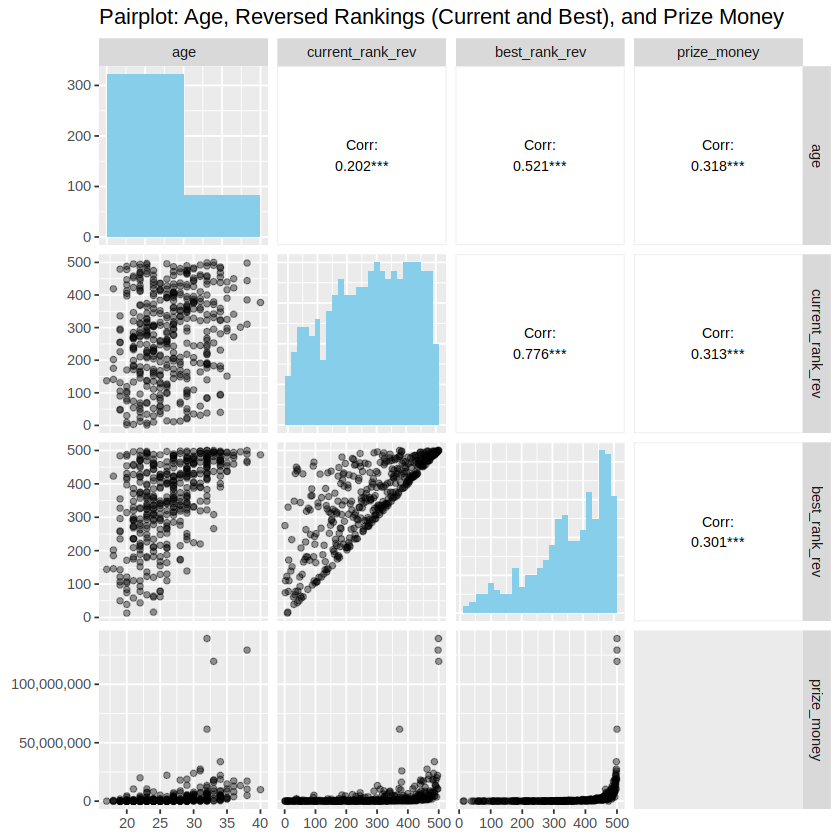

In [37]:
# Pairplot to show basic data comparisons and expected correlation
# !!!!! Update axis, title, etc. to be more readable, and maybe more colorful?
# !!!!! Error with both scale axis and binwidth for prize_money + prize_money plot. Can you set the binwidth for individual plots?

tennis_pairplot <- tennis_data_tidy |> 
    select(age, current_rank_rev, best_rank_rev, prize_money) |>
    ggpairs(lower = list(continuous = wrap('points', 
                                         alpha = 0.4, 
                                         color = "black")),
            diag = list(continuous = wrap('barDiag', binwidth = 20, fill = "skyblue")),
            upper = list(continuous = wrap('cor', size = 3, color = "black"))) +
            theme(text = element_text(size = 11)) +
  scale_y_continuous(labels = scales::comma) +
  ggtitle("Pairplot: Age, Reversed Rankings (Current and Best), and Prize Money")

tennis_pairplot


Made some basic visualizations (explain why we decided to use log of prize money instead etc. maybe even add in some of this before the pairplot?)...

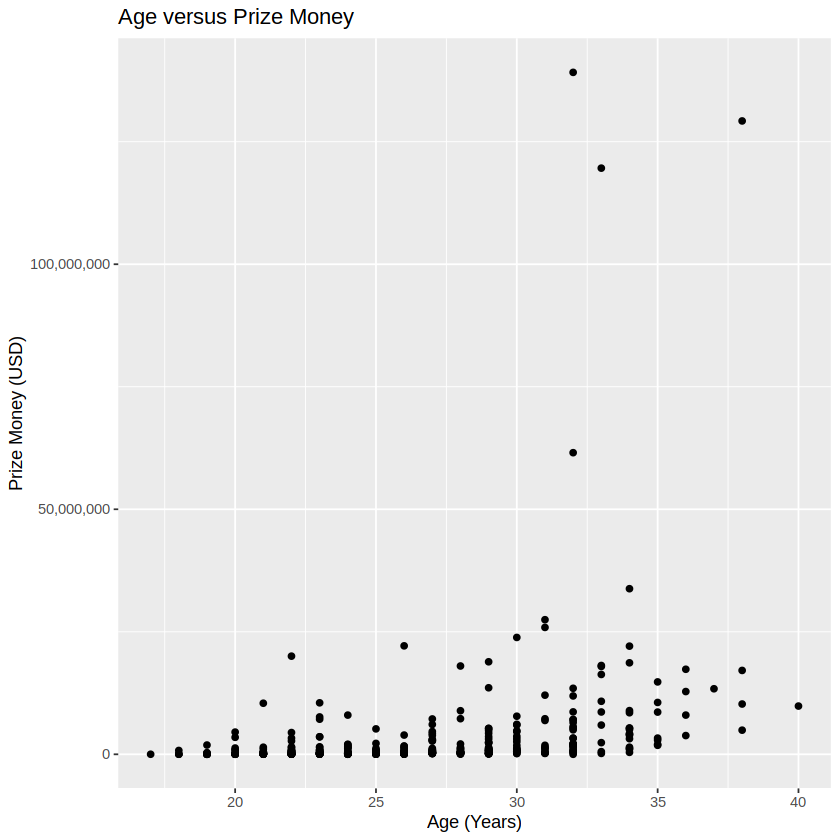

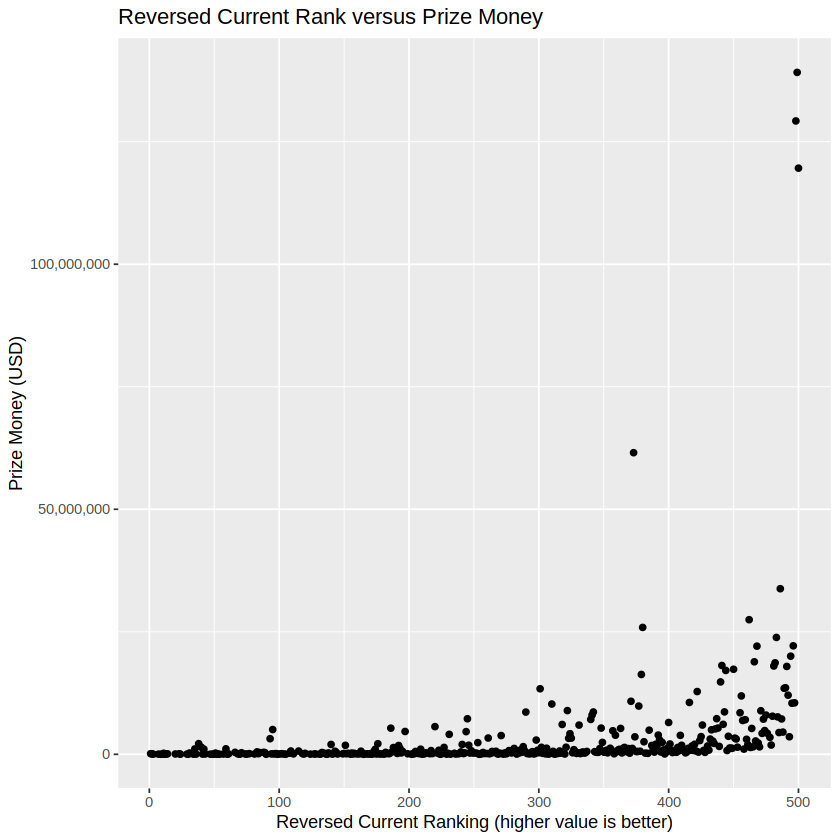

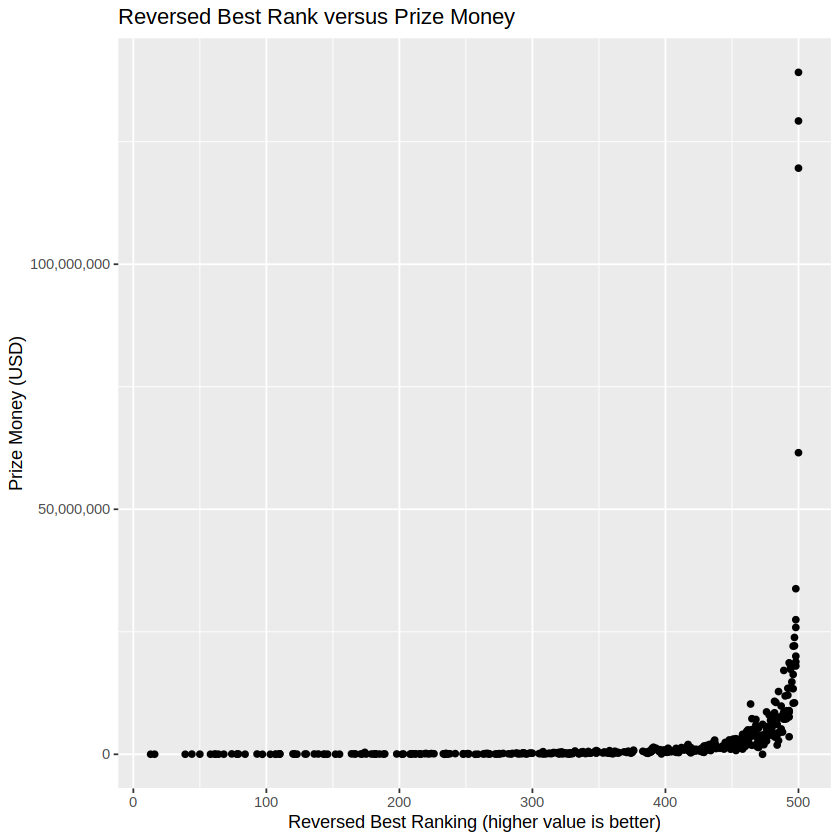

In [38]:
# Scatter plot to compare best rank versus prize money, copy later on for regression line addition 
# Make sure to note why these plots are not as useful as logged versions of them
# !!!!! Maybe make these plots next to eachother? Using facet_wrap or otherwise?

prize_age_plot <- ggplot(tennis_data_tidy, 
                    aes(x= age, y= prize_money)) +
    geom_point() +
    labs(x= "Age (Years)",
         y= "Prize Money (USD)") +
    scale_y_continuous(labels = scales::comma) +
    ggtitle("Age versus Prize Money")

prize_current_rank_plot <- ggplot(tennis_data_tidy, 
                             aes(x= current_rank_rev, y= prize_money)) +
    geom_point() +
    labs(x= "Reversed Current Ranking (higher value is better)",
         y= "Prize Money (USD)") +
    scale_y_continuous(labels = scales::comma) +
    ggtitle("Reversed Current Rank versus Prize Money")

prize_best_rank_plot <- ggplot(tennis_data_tidy, 
                          aes(x= best_rank_rev, y= prize_money)) +
    geom_point() +
    labs(x= "Reversed Best Ranking (higher value is better)",
         y= "Prize Money (USD)") +
    scale_y_continuous(labels = scales::comma) +
    ggtitle("Reversed Best Rank versus Prize Money")
    

prize_age_plot
prize_current_rank_plot
prize_best_rank_plot


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


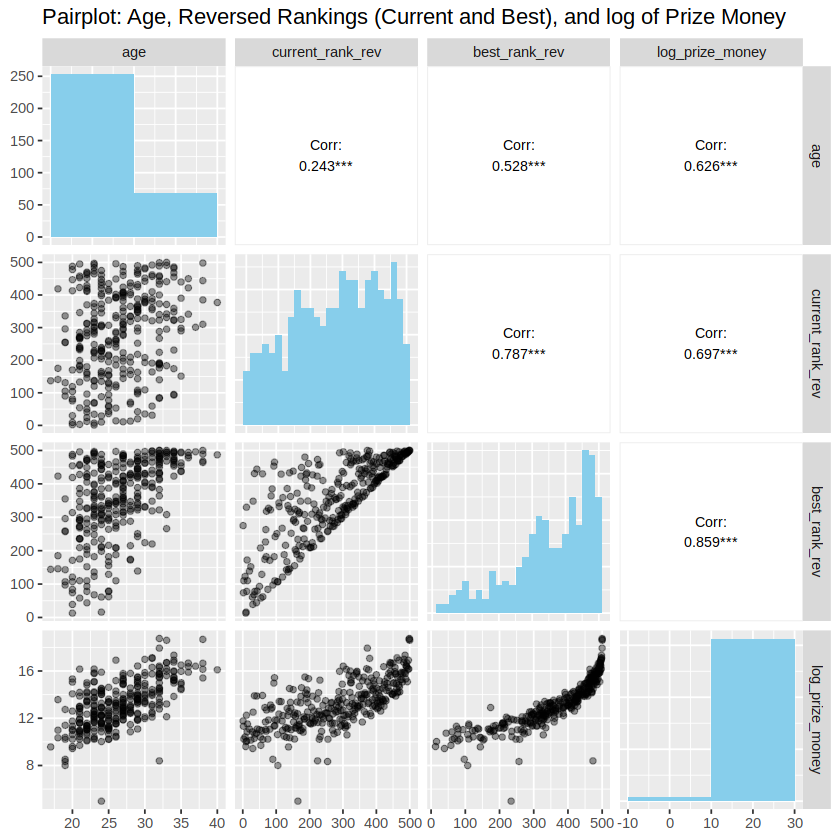

In [40]:
tennis_pairplot_2 <- training_data |> 
    select(age, current_rank_rev, best_rank_rev, log_prize_money) |>
    ggpairs(lower = list(continuous = wrap('points', 
                                         alpha = 0.4, 
                                         color = "black")),
            diag = list(continuous = wrap('barDiag', binwidth = 20, fill = "skyblue")),
            upper = list(continuous = wrap('cor', size = 3, color = "black"))) +
            theme(text = element_text(size = 11)) +
  scale_y_continuous(labels = scales::comma) +
  ggtitle("Pairplot: Age, Reversed Rankings (Current and Best), and log of Prize Money")

tennis_pairplot_2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


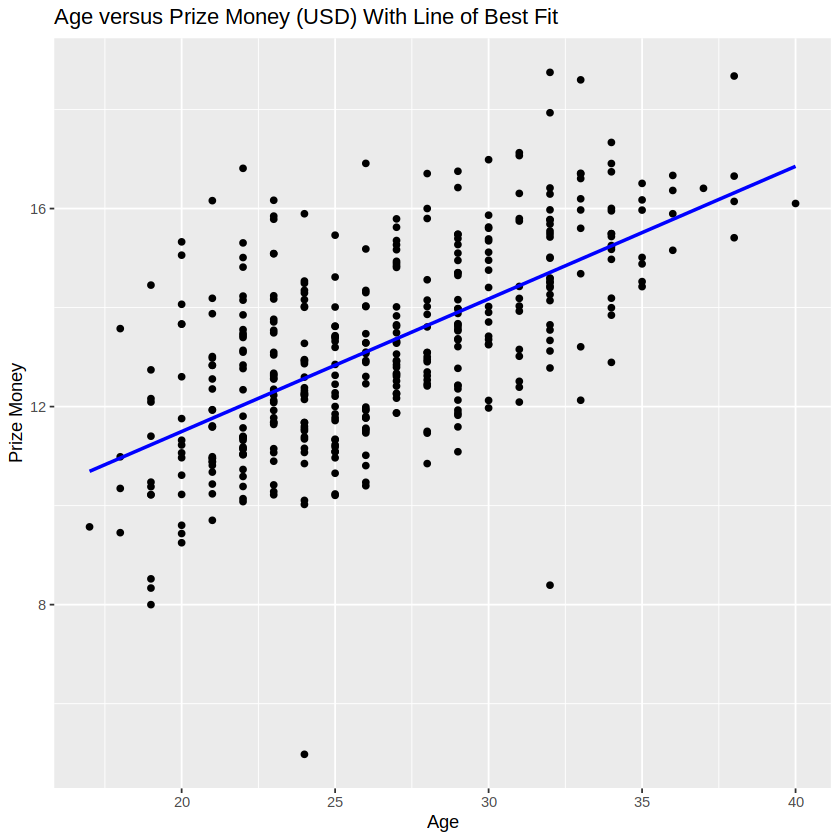

`geom_smooth()` using formula = 'y ~ x'


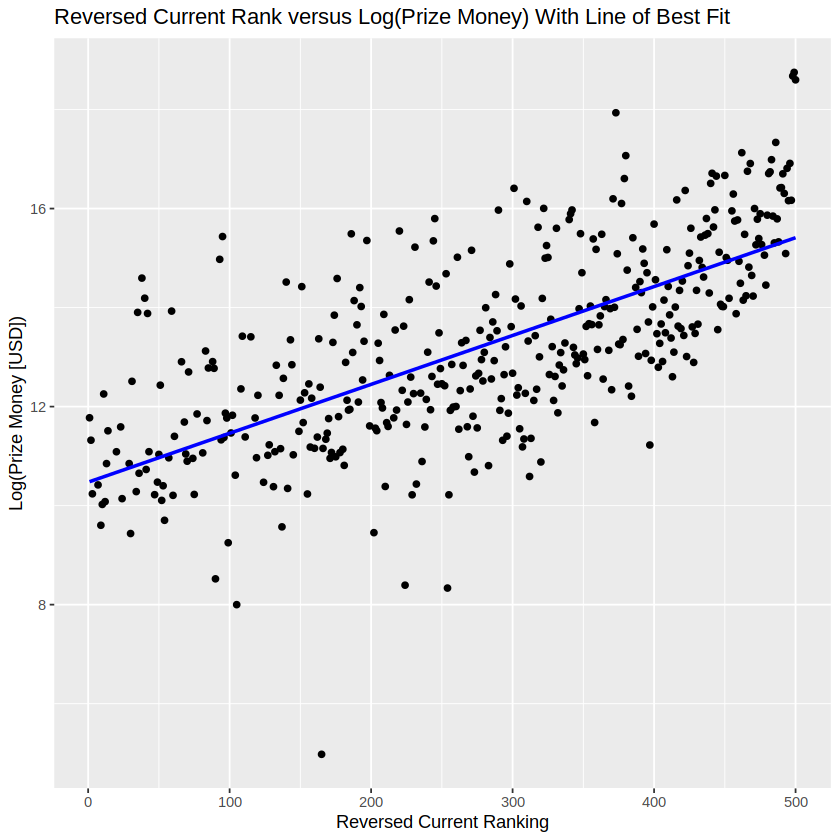

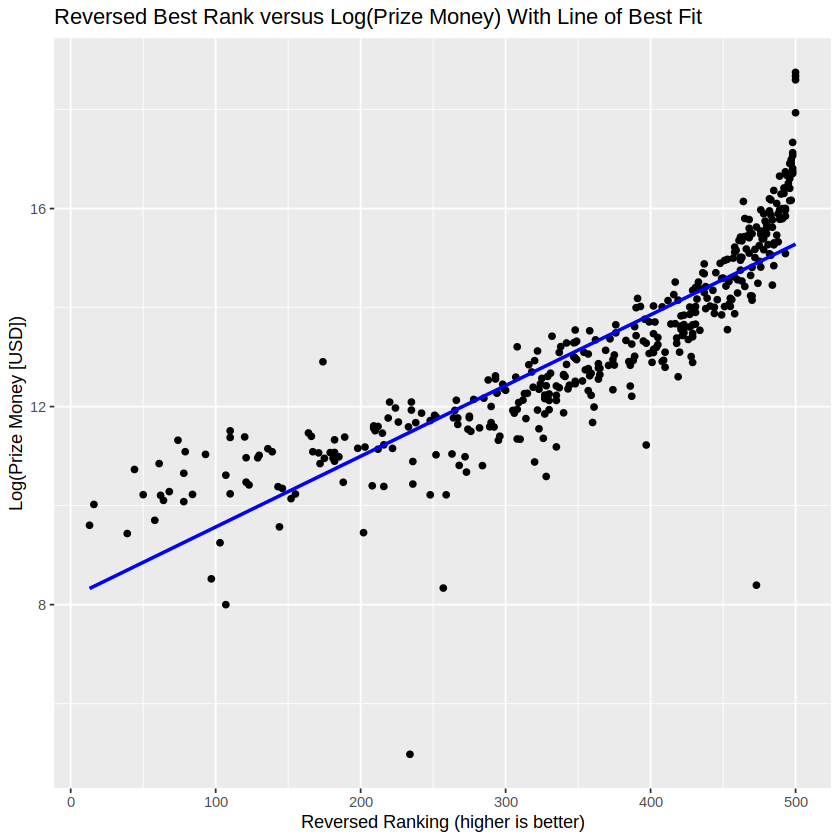

In [39]:
# Scatter plots with log scale for prize money and basic linear regression line, using the 
# Versus best rank, current rank, and age
# !!!!! Go through and standardize axis and titles for graphs 
# !!!!! Make these graphs pretty 

prize_age_line <- ggplot(tennis_data_tidy, 
                         aes(x= age, 
                             y= log_prize_money)) +
    geom_point() +
    labs(x= "Age (Years)",
         y= "Prize Money (USD)") +
    scale_y_continuous(labels = scales::comma) +
    ggtitle("Age versus Prize Money")  +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +  # Add linear regression line
  labs(x = "Age",
       y = "Prize Money") +
  ggtitle("Age versus Prize Money (USD) With Line of Best Fit")


prize_current_rank_log_line <- ggplot(tennis_data_tidy, 
                                      aes(x = current_rank_rev, 
                                          y = log_prize_money)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +  # Add linear regression line
  labs(x = "Reversed Current Ranking",
       y = "Log(Prize Money [USD])") +
  ggtitle("Reversed Current Rank versus Log(Prize Money) With Line of Best Fit")


prize_best_rank_log_line <- ggplot(tennis_data_tidy, 
                                   aes(x = best_rank_rev, 
                                       y = log_prize_money)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +  # Add linear regression line
  labs(x = "Reversed Ranking (higher is better)",
       y = "Log(Prize Money [USD])") +
  ggtitle("Reversed Best Rank versus Log(Prize Money) With Line of Best Fit")



prize_age_line
prize_current_rank_log_line
prize_best_rank_log_line

In [41]:
# !!!!! Make sure to add in set_seed for data analysis if it is required??
# !!!!! Double check what the split proportion should be
tennis_split <- initial_split(tennis_data_tidy, prop = 0.8, strata= log_prize_money) 

training_data <- training(tennis_split)
testing_data <- testing(tennis_split)

lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# Create a recipe for the model
tennis_recipe <- recipe(log_prize_money ~ current_rank_rev + best_rank_rev, 
                        data = training_data)

tennis_fit <- workflow() |>
  add_recipe(tennis_recipe) |>
  add_model(lm_spec) |>
  fit(data = training_data)

# Print the fitted model
tennis_fit

# Print the linear regression specification
print(lm_spec)

# Print the recipe
print(tennis_recipe)



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)  current_rank_rev     best_rank_rev  
       7.9882935         0.0007714         0.0140002  


Linear Regression Model Specification (regression)

Computational engine: lm 

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2


In [42]:

lm_rmse <- tennis_fit |>
  predict(training_data) |>
  bind_cols(training_data) |>
  metrics(truth = log_prize_money, estimate = .pred) |>
  filter(.metric == "rmse") |>
  select(.estimate) |>
  pull()

lm_rmse

[1] 1.015842

In [43]:
 tennis_preds <- tennis_fit |>
  predict(training_data) |>
  bind_cols(training_data)

#lm_predictions <- tennis_preds |>
  #ggplot(aes(x = current_rank_rev, y = log_prize_money)) +
  #geom_point(alpha = 0.4) +
  #geom_line(mapping = aes(x = current_rank_rev, y = .pred), color = "black") +
  #xlab("Reversed Current Rank") +
 # ylab("Log (Prize Money [USD])") +
  #ggtitle("Reversed Current Rank Versus Log (Prize Money)") +
  #theme(text = element_text(size = 12))

#doesn't work

In [44]:
 
# The problem with this graph is that we are using too many variables and 
# so cannot show the regression line as a comparision between 2 variables 
# because it is not that and so there cannot be a straight line on a graph like this... 

#lm_predictions_2 <- tennis_preds |>
#     ggplot(aes(x = current_rank, y = prize_money)) +
#         geom_point(alpha = 0.4) +
#         geom_line(
#             mapping = aes(x = current_rank, y = .pred), 
#             color = "black") +
#         xlab("Current Rank") +
#         ylab("Prize Money (USD)") +
#         theme(text = element_text(size=20))

#lm_predictions_2

### Results and Analysis:

Through this data analysis, we expect to find a correlation between various factors of players and their tennis performance measured via a number of metrics. These findings could help to understand which factors are correlated with better or worse performance in players, perhaps allowing for improvements in the choice of techniques to improve performance or being able to better estimate the performance of newer players. This analysis could lead to further questions about which variables could be changed to improve performance in new athletes, or which metrics of success are most useful for tennis athletes.

